In [1]:
# repitition of abb05, bp on gains and shifts, and then do hebbian learning to transfer learning to weights
# bp first, then without turning off bp, gradually turn on hebbian learning, no active narrowing
# can transfer part of the learning to weights, but not all; converge to a med place where bp and hebb are balanced
# partly because it is not balanced when gains and shifts are totally unmodified
# passively narrow the bound of gains and weights only get a similar result
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from training_abb05_bphebb import SimpleNeuralNetwork

In [2]:
# load the pickle file
with open('weights_abb05_bphebb.pkl', 'rb') as f:
    model = pickle.load(f)
    losses = pickle.load(f)
    weight_sums = pickle.load(f)
    gain_changes = pickle.load(f)
    shift_changes = pickle.load(f)
    saved_epoch = pickle.load(f)
    all_weights = pickle.load(f)
epochs = len(losses)

In [3]:
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

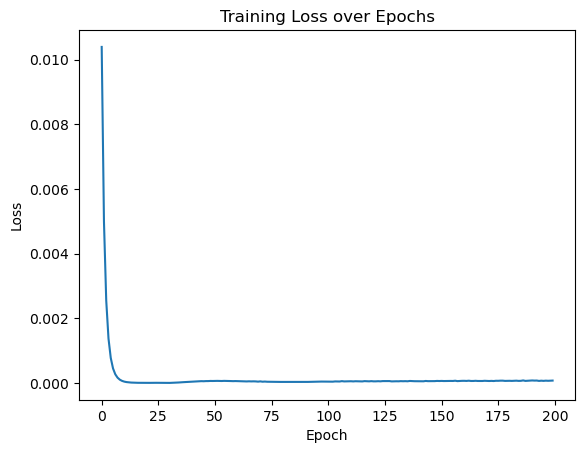

In [4]:
# Plotting the loss
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.005])
plt.title('Training Loss over Epochs')
plt.savefig('fig/0214_abb05_bphebb_loss.png')
plt.show()

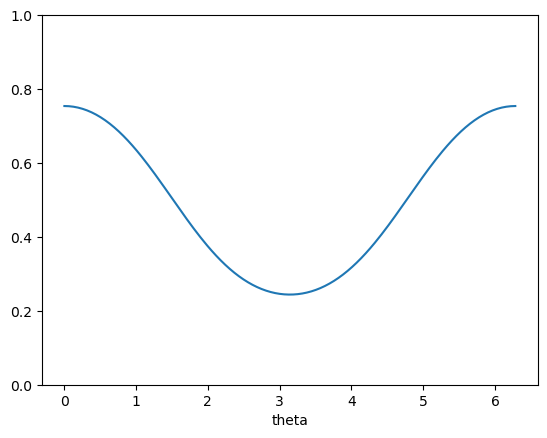

In [5]:
# Plotting the outputs
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs)
plt.ylim([0,1])
plt.xlabel("theta")
# plt.savefig('abb05_outputs.png')
plt.show()

In [6]:
# plt.plot(np.arange(epochs), weight_sums)
# # plt.ylim([0,8])
# plt.xlabel("epoch")
# plt.ylabel("sum of first 100 weights")
# # plt.savefig('abb05_ws.png')
# plt.show()

In [7]:
rates = []
for x in xs:
    input = model.gaussian_rf(x)
    rate = model.activation_func(model.gain * (input - model.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)
rates

array([[0.5   , 0.4996, 0.4985, ..., 0.4985, 0.4996, 0.5   ],
       [0.4997, 0.5   , 0.4995, ..., 0.4969, 0.4987, 0.4997],
       [0.4989, 0.4998, 0.5   , ..., 0.4948, 0.4972, 0.4989],
       ...,
       [0.4989, 0.4972, 0.4948, ..., 0.5   , 0.4998, 0.4989],
       [0.4997, 0.4987, 0.4969, ..., 0.4995, 0.5   , 0.4997],
       [0.5   , 0.4996, 0.4985, ..., 0.4985, 0.4996, 0.5   ]],
      dtype=float32)

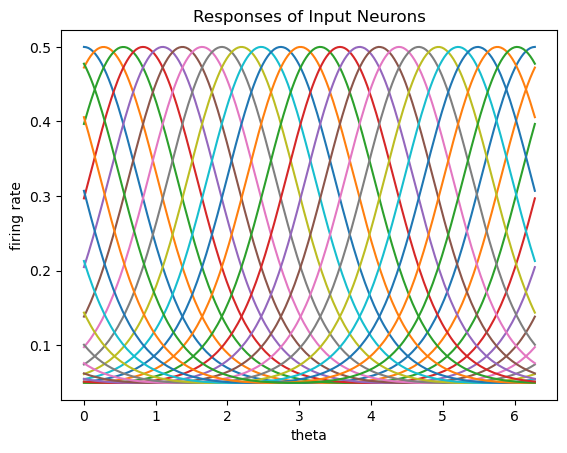

In [8]:
for i in np.arange(0,model.input_size,10):
    thisr = rates[i,:]
    plt.plot(xs, thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
plt.title("Responses of Input Neurons")
plt.savefig('fig/0214_abb05_bphebb_rf.png')

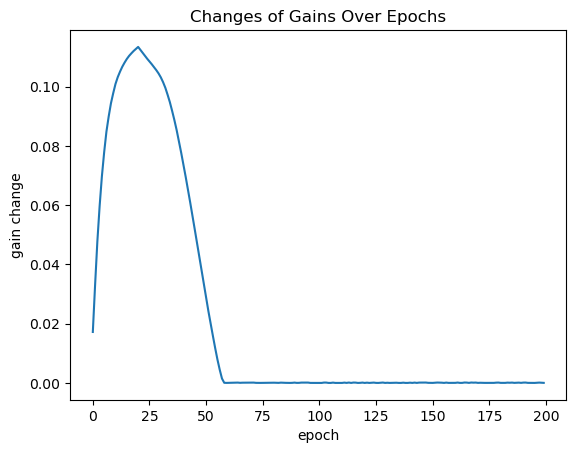

In [9]:
plt.plot(np.arange(epochs), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
plt.title("Changes of Gains Over Epochs")
plt.savefig('fig/0214_abb05_bphebb_gc.png')
plt.show()

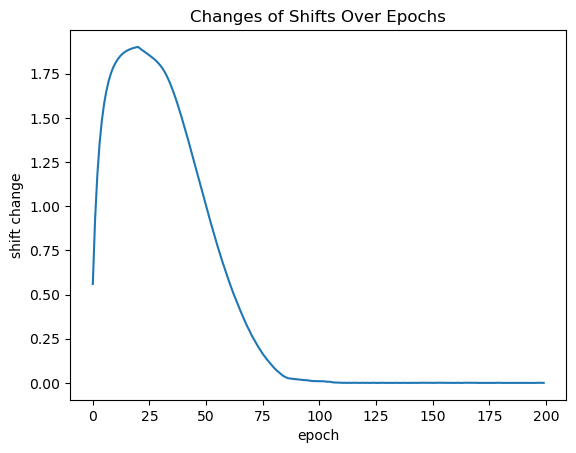

In [10]:
plt.plot(np.arange(epochs), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.ylim([0,0.5])
plt.title("Changes of Shifts Over Epochs")
plt.savefig('fig/0214_abb05_bphebb_sc.png')
plt.show()

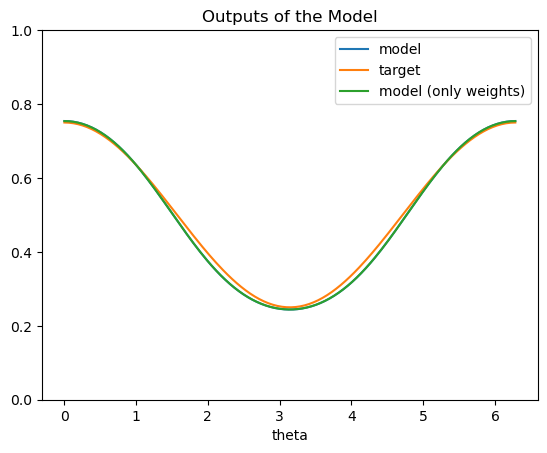

In [11]:
# Plotting the outputs
# least_saved_epoch = (np.argmin(losses[100::]) + 100) // 20 * 20
# least_idx = np.where(np.array(saved_epoch) == least_saved_epoch)[0].item()
# final_weights = all_weights[least_idx]
final_weights = all_weights[-1]
final_model = SimpleNeuralNetwork(model.input_size, model.init_gain.detach().numpy(), model.init_shift.detach().numpy(), final_weights)
outputs_wt = []
for x in xs:
    output = final_model(x)
    outputs_wt.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.plot(xs, outputs_wt, label='model (only weights)')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
plt.title("Outputs of the Model")
plt.savefig('fig/0214_abb05_bphebb_output.png')

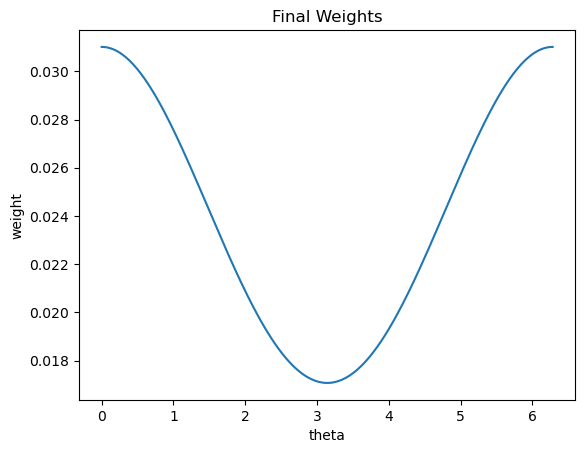

In [12]:
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), final_weights.flatten())
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
plt.title("Final Weights")
plt.savefig('fig/0214_abb05_bphebb_weights.png')

In [13]:
# plt.plot(np.linspace(0, 2 * np.pi, model.input_size), all_weights[-1].flatten())
# # plt.ylim([0,8])
# plt.xlabel("theta")
# plt.ylabel("weight")
# # plt.savefig('abb05_ws.png')
# plt.show()

In [14]:
# # plot the difference of max and min for all weights
# diffs = []
# for weights in all_weights:
#     diffs.append(np.max(weights) - np.min(weights))
# # plt.plot(np.arange(0,20*len(diffs),20), diffs)
# plt.plot(diffs)